# Total Divergence Potential

This notebook is for calculating total divergence potential vs pseudotime

### Data Preprocessing

In [2]:
import scvelo as scv
import scanpy as sc
import numpy as np
import sklearn
scv.set_figure_params()

In [3]:
adata = scv.datasets.dentategyrus_lamanno()
adata_raw = adata.copy()
sc.pp.neighbors(adata)
sc.tl.umap(adata)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


         Falling back to preprocessing with `sc.pp.pca` and default params.


In [4]:
scv.pp.filter_and_normalize(adata, min_shared_counts=20, n_top_genes=2000)
scv.pp.filter_and_normalize(adata_raw, log=False, min_shared_counts=20, n_top_genes=2000)
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)

Filtered out 18710 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
Logarithmized X.
Filtered out 18710 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
computing neighbors
    finished (0:00:04) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:02) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


recovering dynamics (using 2/28 cores)
or disable the progress bar using `show_progress_bar=False`.
    finished (0:20:57) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:23) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 2/28 cores)
    finished (0:01:49) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:05) --> added
    'velocity_tsne', embedded velocity vectors (adata.obsm)


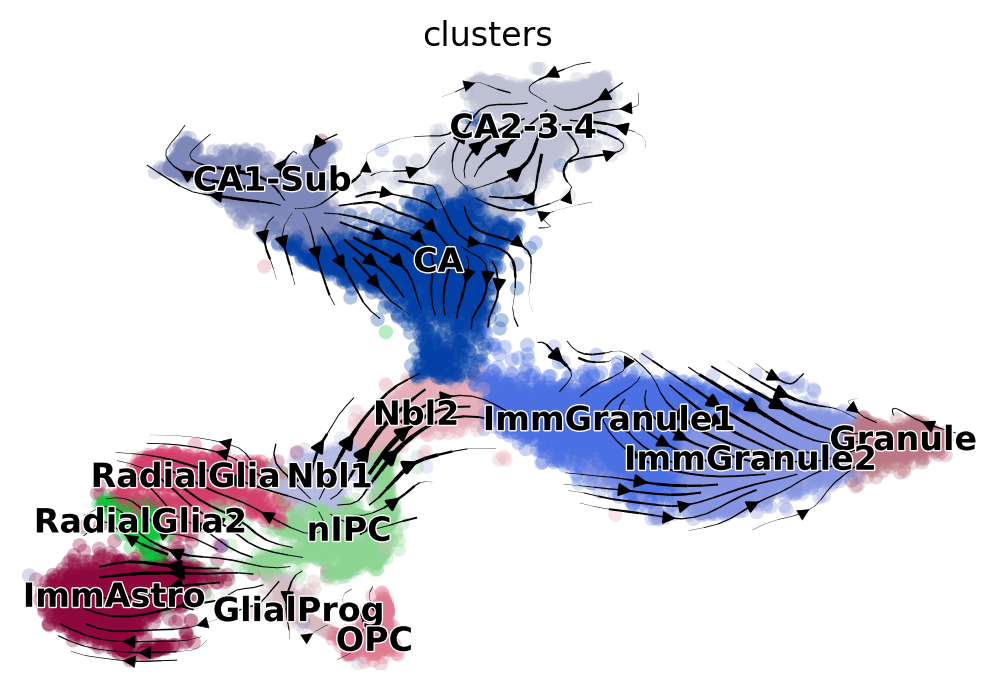

computing terminal states
    identified 4 regions of root cells and 2 regions of end points .
    finished (0:00:02) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
computing latent time using root_cells as prior
    finished (0:00:07) --> added 
    'latent_time', shared time (adata.obs)


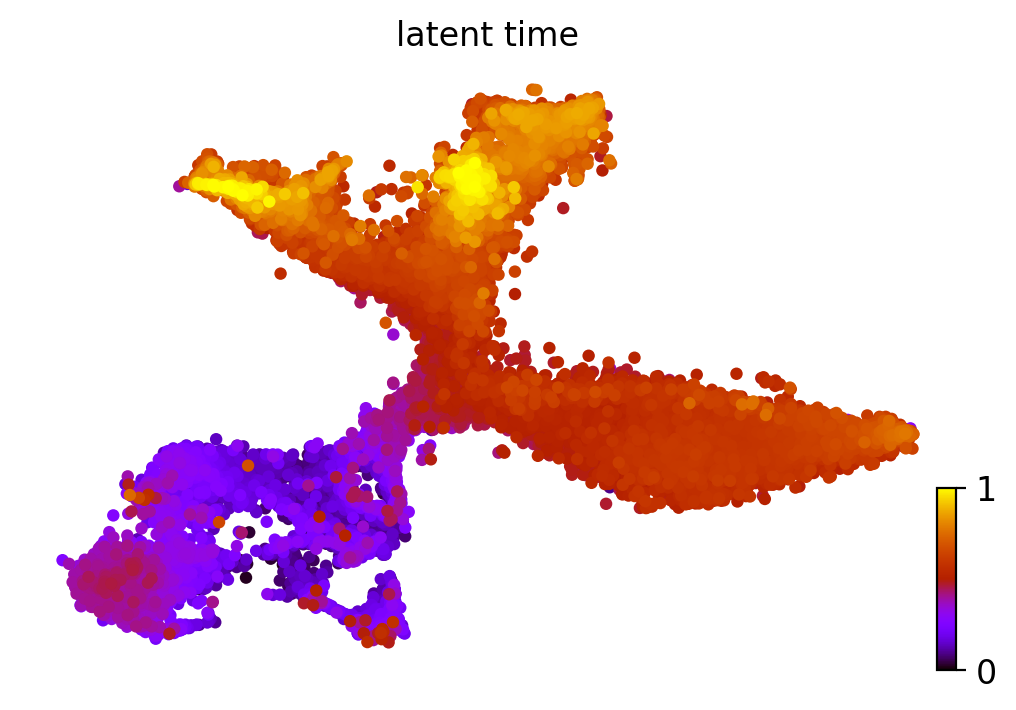

In [5]:
# Extract dynamical velocity vectors
scv.tl.recover_dynamics(adata, n_jobs=2)
scv.tl.velocity(adata, mode='dynamical', use_raw=True)
scv.tl.velocity_graph(adata, n_jobs=2)
scv.pl.velocity_embedding_stream(adata, basis='tsne')

# Latent time inference
scv.tl.latent_time(adata)
scv.pl.scatter(adata, color='latent_time', color_map='gnuplot', basis='tsne', size=80)

In [6]:
X = np.tile(adata_raw.X.A[:, adata.var["velocity_genes"]], (5, 1))
Y = np.tile(adata.layers["velocity"][:, adata.var["velocity_genes"]], (5, 1))
noise_sigma = (adata_raw.X.A.std()/70)**2
X[adata_raw.shape[0]:, :] += \
    np.random.normal(0, noise_sigma, X[adata_raw.shape[0]:, :].shape)

X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, 
                                                    Y, 
                                                    test_size=0.1, 
                                                    random_state=42)

# we see that noise has been added to denoise the autoencoder
print(X[:100])
print(X[adata_raw.shape[0]:(adata_raw.shape[0]+100), :])

[[0.        0.        0.        ... 0.        0.        0.       ]
 [0.        0.        0.        ... 0.6629593 0.        0.6629593]
 [0.        0.        0.        ... 0.        0.        1.5268502]
 ...
 [0.        0.        0.        ... 0.        0.        0.       ]
 [0.        0.        0.361451  ... 0.361451  0.        1.084353 ]
 [0.        0.        1.3105614 ... 0.6552807 0.        1.3105614]]
[[-1.3977767e-03  9.1884891e-04  1.4879059e-03 ... -1.5205919e-03
  -2.0506955e-03  1.3952741e-03]
 [-3.3162700e-03  1.4585153e-03 -6.1006291e-04 ...  6.6362882e-01
  -5.9138431e-04  6.6058773e-01]
 [-6.0346039e-05  3.9514279e-04  1.6376837e-03 ...  5.6365901e-04
  -2.5903878e-03  1.5281098e+00]
 ...
 [ 1.2066803e-03 -1.6158656e-03  1.9717948e-03 ... -1.6785681e-03
   4.4273125e-04  2.6990357e-03]
 [ 1.3576223e-03  1.5152269e-03  3.6165211e-01 ...  3.6116591e-01
   1.3334764e-03  1.0832897e+00]
 [ 2.1567791e-04  1.1153742e-03  1.3103938e+00 ...  6.5551919e-01
  -7.4090704e-04  1.310634

### Model Training

In [7]:
from tensorflow import keras
from tensorflow.keras import layers
import sklearn
import numpy as np
import tensorflow as tf
import scipy 

tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [8]:
input_dim = keras.Input(shape=(X.shape[1],))
encoded = layers.Dense(64, kernel_regularizer=keras.regularizers.l1(1e-6))(input_dim)
encoded = layers.Dense(16, kernel_regularizer=keras.regularizers.l1(1e-2))(encoded)

decoded = layers.Dense(16, kernel_regularizer=keras.regularizers.l1(1e-4))(encoded)
decoded = layers.Dense(64, kernel_regularizer=keras.regularizers.l1(1e-6))(decoded)
decoded = layers.Dense(Y.shape[1])(decoded)

# This model maps an input to its reconstruction
encoder = keras.Model(input_dim, encoded)
autoencoder = keras.Model(input_dim, decoded)

opt = keras.optimizers.Adam(learning_rate=0.00007)
autoencoder.compile(optimizer=opt, loss='mse')
autoencoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1067)]            0         
_________________________________________________________________
dense (Dense)                (None, 64)                68352     
_________________________________________________________________
dense_1 (Dense)              (None, 16)                1040      
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_3 (Dense)              (None, 64)                1088      
_________________________________________________________________
dense_4 (Dense)              (None, 1067)              69355     
Total params: 140,107
Trainable params: 140,107
Non-trainable params: 0
_____________________________________________________

2021-11-11 16:25:17.070221: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-11-11 16:25:17.575792: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15405 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:81:00.0, compute capability: 6.0


In [9]:
autoencoder = keras.models.load_model("total_kl_dentategyrus.h5")

In [8]:
es = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
autoencoder.fit(X_train, y_train,
        epochs=100,
        batch_size=2,
        shuffle=True,
        validation_data=(X_test, y_test),
        callbacks=[es])
autoencoder.save("total_kl_dentategyrus.h5")

2021-11-07 14:42:18.782755: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100
40979/40979 [==============================] - 63s 1ms/step - loss: 0.1366 - val_loss: 0.0540
Epoch 2/100
40979/40979 [==============================] - 58s 1ms/step - loss: 0.0517 - val_loss: 0.0507
Epoch 3/100
40979/40979 [==============================] - 58s 1ms/step - loss: 0.0497 - val_loss: 0.0493
Epoch 4/100
40979/40979 [==============================] - 58s 1ms/step - loss: 0.0483 - val_loss: 0.0481
Epoch 5/100
40979/40979 [==============================] - 58s 1ms/step - loss: 0.0476 - val_loss: 0.0482
Epoch 6/100
40979/40979 [==============================] - 58s 1ms/step - loss: 0.0472 - val_loss: 0.0473
Epoch 7/100
40979/40979 [==============================] - 58s 1ms/step - loss: 0.0469 - val_loss: 0.0471
Epoch 8/100
40979/40979 [==============================] - 60s 1ms/step - loss: 0.0468 - val_loss: 0.0469
Epoch 9/100
40979/40979 [==============================] - 60s 1ms/step - loss: 0.0466 - val_loss: 0.0471
Epoch 10/100
40979/40979 [====================

### Total Divergence Calculations

In [10]:
from scipy.integrate import odeint, solve_ivp
import umap
import matplotlib.pyplot as plt

In [11]:
pca = sklearn.decomposition.PCA(n_components=30)
adata_pca = pca.fit_transform(np.log1p(adata_raw.X.A[:, adata.var["velocity_genes"]]))
umap_reducer = umap.UMAP(random_state=42, n_neighbors=30, min_dist=0.25)
adata_umap = umap_reducer.fit_transform(adata_pca)
neigh = sklearn.neighbors.NearestNeighbors(n_neighbors=30)
neigh.fit(adata_pca)

# ODE Solver Function
def raw_ae(t, in_x):
    input_x = tf.convert_to_tensor(np.expand_dims(in_x, axis=0))
    dx = autoencoder.predict(input_x).flatten()
    return dx

In [12]:
# Interpolate over time
def interpolate(y0, neigh=neigh, pca=pca, umap_reducer=umap_reducer, steps=10, intermediate_steps=5):
    
    solution = []
    for step in range(steps):
        
        # Interpolate using autoencoder
        t_eval = list(range(intermediate_steps))
        sol = solve_ivp(raw_ae, [0,max(t_eval)], y0, method="RK23", t_eval=t_eval)
        y = sol.y.T
        
        # Lower dimensionality
        ending_pt_pca = pca.transform(np.nan_to_num(np.log1p(y)))
        
        # Find knn reference points
        interp_neigh = neigh.kneighbors(ending_pt_pca)
        
        # New reference point
        y0 = np.median(X[interp_neigh[1][-1, :], :], axis=0)
        solution.append(y0)
    
    return np.array(solution)

In [12]:
# def interpolate(y0, neigh, pca, reducer, steps=10, intermediate_steps=5):
    
#     solution = []
#     for step in range(steps):
        
#         # Interpolate using autoencoder
#         t_eval = list(range(intermediate_steps))
#         sol = solve_ivp(raw_ae, [0,max(t_eval)], y0, method="RK23", t_eval=t_eval)
#         y = sol.y.T
#         print(y[-1, :])
        
#         # Lower dimensionality
#         ending_pt_pca = pca.transform(np.nan_to_num(np.log1p(y)))
#         ending_pt = reducer.transform(ending_pt_pca)
        
#         # Find knn reference points
#         interp_neigh = neigh.kneighbors(ending_pt_pca)
#         print(interp_neigh[1][-1, :])
        
#         # New reference point
#         y0 = np.median(X[interp_neigh[1][-1, :], :], axis=0)
#         solution.append(y0)
        
#         # Plot UMAP directions
#         plt.figure(figsize=(10,3))
#         plt.subplot(1, 3, 1)
#         plt.scatter(adata_umap[:, 0], adata_umap[:, 1], 
#                     s=1, alpha=0.5)
#         plt.scatter(ending_pt[:, 0], 
#                     ending_pt[:, 1], 
#                     c=np.arange(ending_pt.shape[0]), 
#                     cmap="viridis",
#                     s=20
#                    )
#         plt.colorbar()
#         plt.scatter(ending_pt[0, 0], ending_pt[0, 1], s=20, color="red")
#         plt.gca().set_aspect('equal', 'datalim')
        
#         # Plot PCA directions
#         plt.subplot(1, 3, 2)
#         plt.scatter(adata_pca[:, 0], 
#                     adata_pca[:, 1], 
#                     s=1, 
#                     alpha=0.5)
#         plt.scatter(ending_pt_pca[:, 0], 
#                     ending_pt_pca[:, 1], 
#                     c=np.arange(ending_pt.shape[0]), 
#                     cmap="viridis",
#                     s=20
#                    )
#         plt.colorbar()
#         plt.scatter(ending_pt_pca[0, 0], ending_pt_pca[0, 1], 
#                     s=20, color="red")
#         plt.gca().set_aspect('equal', 'datalim')

#         plt.subplot(1, 3, 3)
#         plt.scatter(adata_pca[:, 1], 
#                     adata_pca[:, 2], 
#                     s=1, 
#                     alpha=0.5)
#         plt.scatter(ending_pt_pca[:, 1], 
#                     ending_pt_pca[:, 2], 
#                     c=np.arange(ending_pt.shape[0]), 
#                     cmap="viridis",
#                     s=20
#                    )
#         plt.colorbar()
#         plt.scatter(ending_pt_pca[0, 1], ending_pt_pca[0, 2], 
#                     s=20, color="red")
#         plt.gca().set_aspect('equal', 'datalim')
#         plt.show()
    
#     return np.array(solution)

# print(np.unique(adata.obs.clusters))
# y0 = X[np.where(adata.obs.clusters == "CA")[0][7], :]
# print(y0.shape)
# y_solution = interpolate(y0, neigh=neigh, pca=pca, reducer=umap_reducer)

In [ ]:
all_paths = np.zeros((adata[:, adata.var["velocity_genes"]].shape[0], 
                      10, 
                      adata[:, adata.var["velocity_genes"]].shape[1]))
for i in range(adata.shape[0]):
    if (i % 500 == 0):
        print(i)
        np.save('all_paths_dentategyrus.npy', all_paths)
    all_paths[i, :, :] = interpolate(adata_raw.X[i, adata.var["velocity_genes"]].A.flatten(), 
                                     neigh = neigh, 
                                     pca = pca, 
                                     umap_reducer = umap_reducer)

np.save('all_paths_dentategyrus.npy', all_paths)

0
500
1000
1500
2000


In [ ]:
# a = all_paths[i, j, :] / all_paths[i, j, :].sum()
# b = all_paths[i, j+1, :] / all_paths[i, j+1, :].sum()
# c = scipy.special.rel_entr(a,b)
# c[c == np.inf] = 0
# np.sum(c)

In [13]:
all_paths = np.load('all_paths_dentategyrus.npy')

In [16]:
import scipy
all_paths_entropy = np.zeros(adata[:, adata.var["velocity_genes"]].shape[0])
for i in range(all_paths.shape[0]):
    for j in range(9):
        a = all_paths[i, j, :] / all_paths[i, j, :].sum()
        b = all_paths[i, j+1, :] / all_paths[i, j+1, :].sum()
        c = scipy.special.kl_div(a,b)
        c[c == np.inf] = 0
        all_paths_entropy[i] += np.sum(c)
print(all_paths_entropy)


[0.2126344  0.23321633 0.18422355 ... 0.65520558 0.26765907 0.27464051]


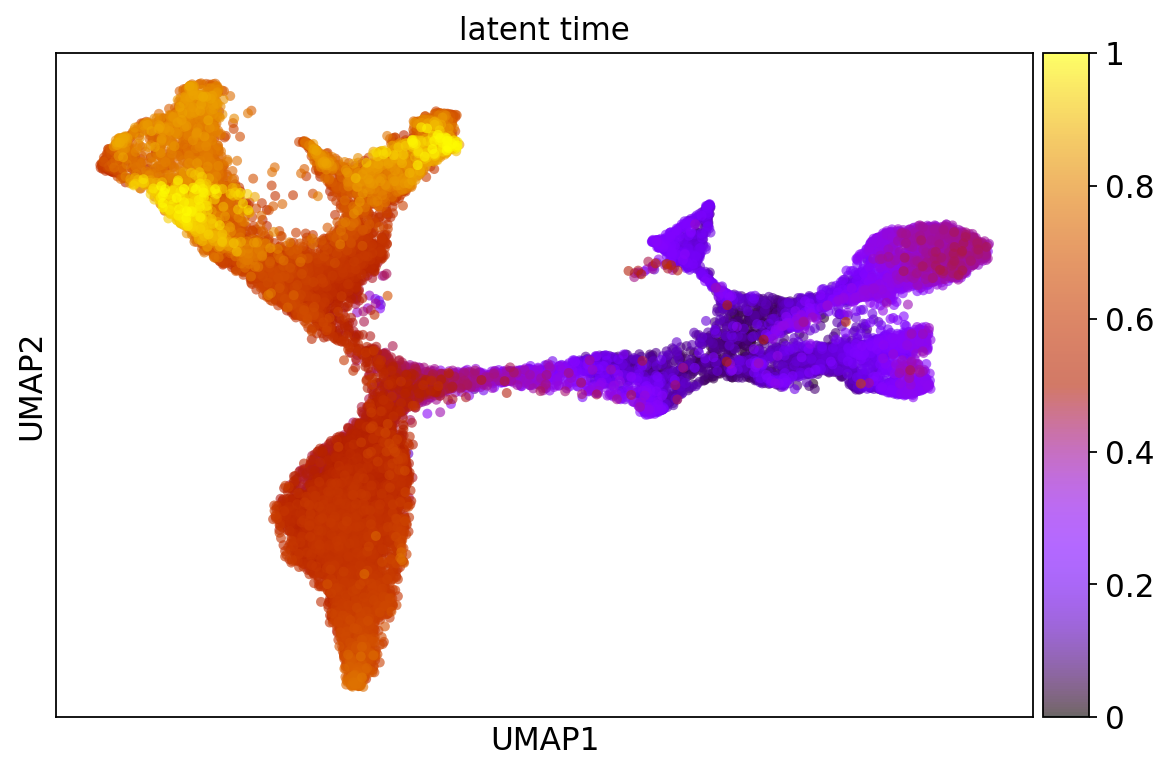

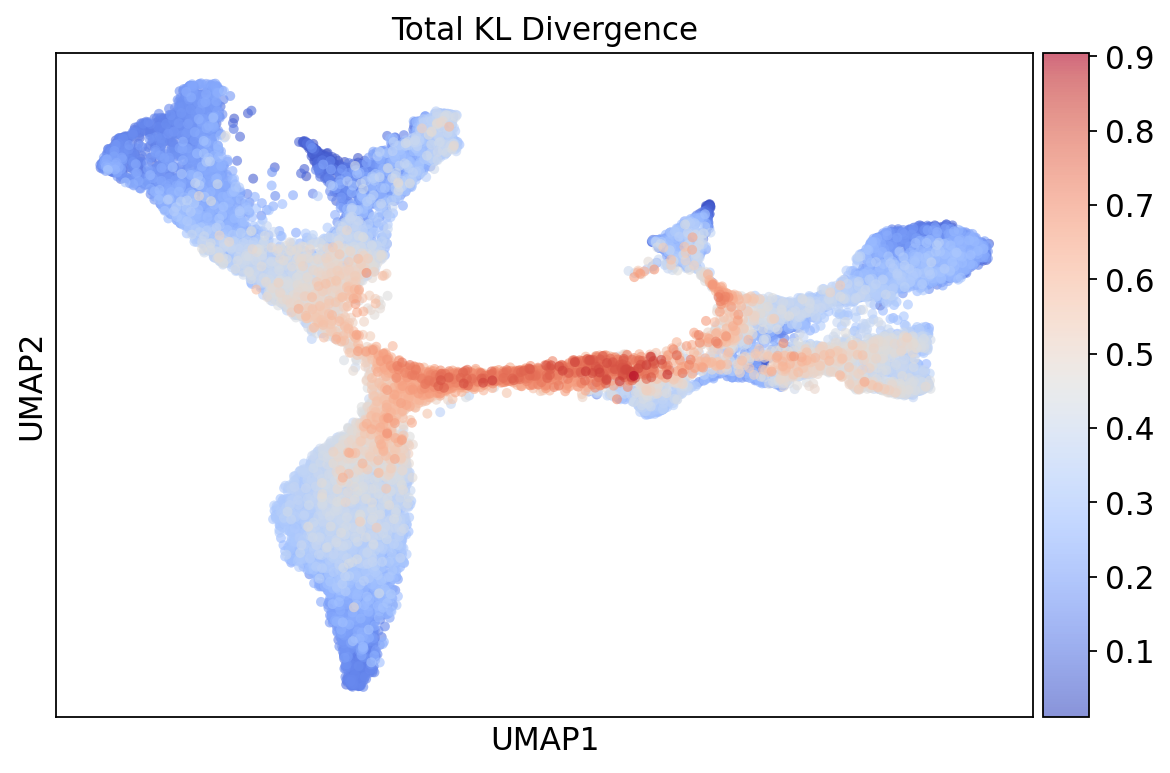

In [22]:
adata.obsm["X_umap"] = adata_umap
sc.pl.scatter(adata, color=['latent_time'], basis="umap", 
              color_map='gnuplot', size=80, save="latent_time_dentategyrus_umap", alpha=0.6)
sc.pl.scatter(adata, color=['Total KL Divergence'], basis="umap", 
              color_map='coolwarm', size=80, save="total_kl_dentategyrus_umap", alpha=0.6)

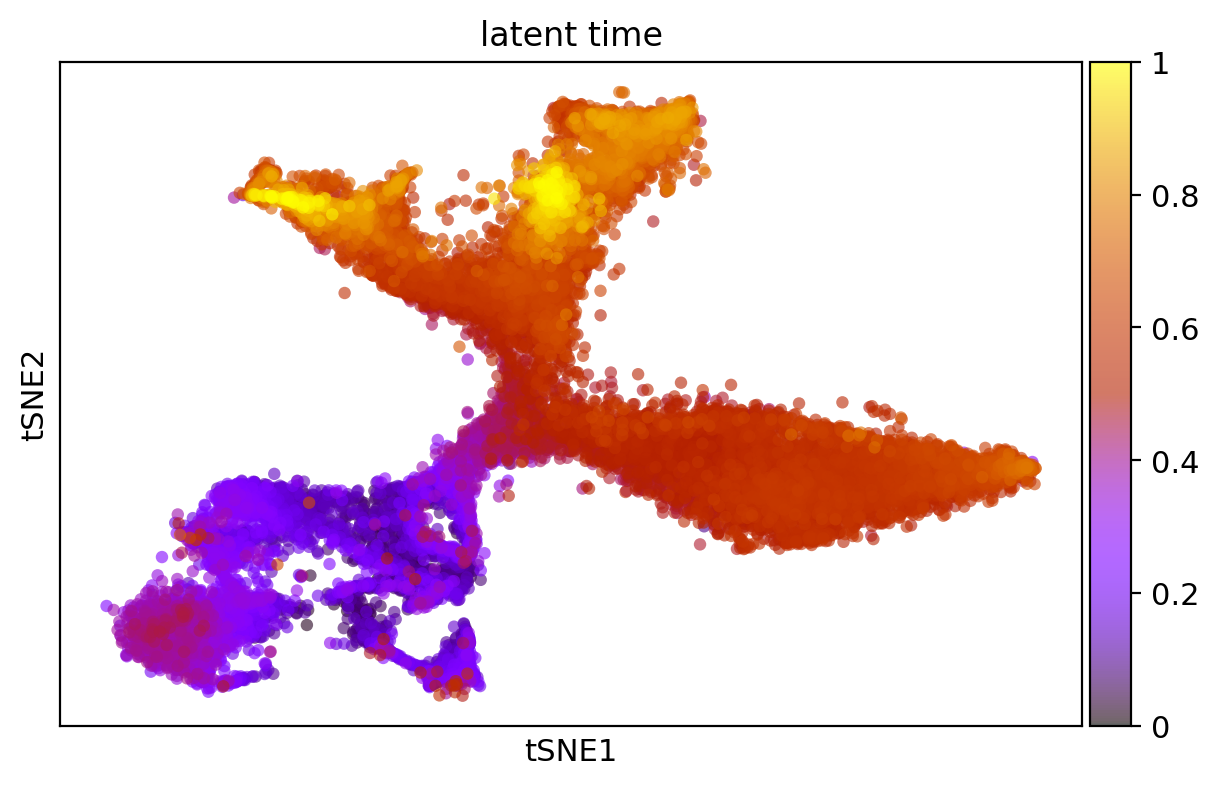

In [17]:
sc.pl.scatter(adata, color=['latent_time'], basis="tsne", 
              color_map='gnuplot', size=80, save="latent_time_dentategyrus", alpha=0.6)

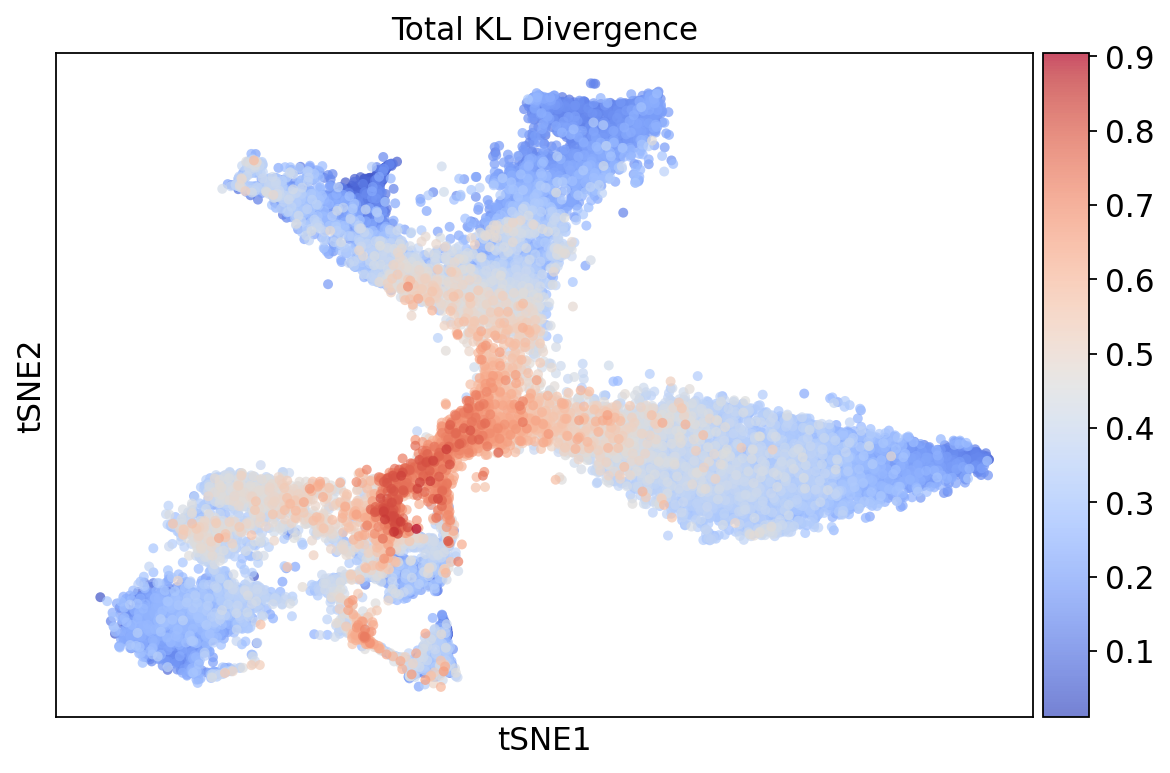

In [18]:
adata.obs["Total KL Divergence"] = all_paths_entropy
sc.set_figure_params(figsize=(7,5))
sc.pl.scatter(adata, color=["Total KL Divergence"], 
              basis="tsne", color_map="coolwarm", save="total_kl_dentategyrus", size=80, alpha=0.7)

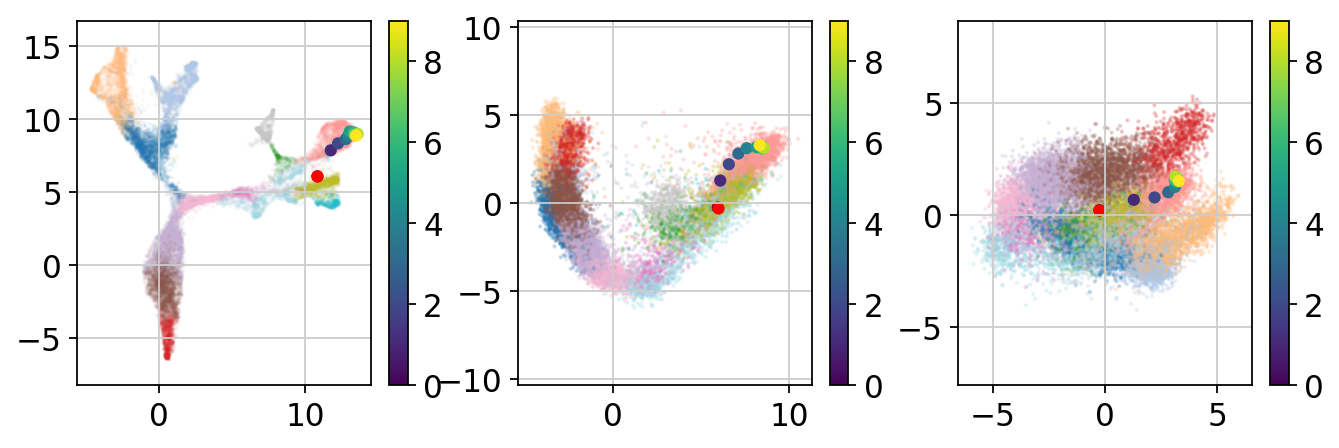

In [19]:
y_solution = all_paths[120]
# Lower dimensionality
ending_pt_pca = pca.transform(np.nan_to_num(np.log1p(y_solution)))
ending_pt = umap_reducer.transform(ending_pt_pca)
        
# Plot UMAP directions
plt.figure(figsize=(10,3))
plt.subplot(1, 3, 1)
plt.scatter(adata_umap[:, 0], adata_umap[:, 1], 
            s=1, alpha=0.05, 
            cmap="tab20",
            c=adata.obs.clusters.cat.codes.to_numpy())
plt.scatter(ending_pt[:, 0], 
            ending_pt[:, 1], 
            c=np.arange(ending_pt.shape[0]), 
            cmap="viridis",
            s=20
           )
plt.colorbar()
plt.scatter(ending_pt[0, 0], ending_pt[0, 1], s=20, color="red")
plt.gca().set_aspect('equal', 'datalim')

# Plot PCA directions
plt.subplot(1, 3, 2)
plt.scatter(adata_pca[:, 0], 
            adata_pca[:, 1], 
            s=1, 
            alpha=0.2, 
            cmap="tab20",
            c=adata.obs.clusters.cat.codes.to_numpy())
plt.scatter(ending_pt_pca[:, 0], 
            ending_pt_pca[:, 1], 
            c=np.arange(ending_pt.shape[0]), 
            cmap="viridis",
            s=20
           )
plt.colorbar()
plt.scatter(ending_pt_pca[0, 0], ending_pt_pca[0, 1], 
            s=20, color="red")
plt.gca().set_aspect('equal', 'datalim')

plt.subplot(1, 3, 3)
plt.scatter(adata_pca[:, 1], 
            adata_pca[:, 2], 
            s=1, 
            alpha=0.2, 
            cmap="tab20",
            c=adata.obs.clusters.cat.codes.to_numpy())
plt.scatter(ending_pt_pca[:, 1], 
            ending_pt_pca[:, 2], 
            c=np.arange(ending_pt.shape[0]), 
            cmap="viridis",
            s=20
           )
plt.colorbar()
plt.scatter(ending_pt_pca[0, 1], ending_pt_pca[0, 2], 
            s=20, color="red")
plt.gca().set_aspect('equal', 'datalim')
plt.show();